# RANDOM FOREST - RETAIL DEMAND PREDICTION

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('final_data.csv')
df.shape

(232265, 58)

In [3]:
df.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH,MANUFACTURER_1,MANUFACTURER_2,...,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,2_MONTH_BEFORE,1_WEEK_BEFORE,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,1,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,1,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0


In [4]:
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

In [5]:
df.dtypes

WEEK_END_DATE                datetime64[ns]
STORE_NUM                             int64
UPC                                   int64
BASE_PRICE                          float64
FEATURE                               int64
DISPLAY                               int64
UNITS                                 int64
MONTH                                 int64
MANUFACTURER_1                        int64
MANUFACTURER_2                        int64
MANUFACTURER_3                        int64
MANUFACTURER_4                        int64
MANUFACTURER_5                        int64
MANUFACTURER_6                        int64
MANUFACTURER_7                        int64
MANUFACTURER_8                        int64
MANUFACTURER_9                        int64
CATEGORY_1                            int64
CATEGORY_2                            int64
CATEGORY_3                            int64
CATEGORY_4                            int64
SUB_CATEGORY_1                        int64
SUB_CATEGORY_2                  

In [6]:
df.drop(columns = ['2_MONTH_BEFORE', '1_WEEK_BEFORE'], axis = 1, inplace = True)

In [7]:
df.isnull().sum().sum()

0

## 1. Validation Sets
* **validation_df** function will create the validation sets.
* It will take the parameters, a list of unique WEEK_END_DATES, dataset and no of months in training period and no of training validation sets required.
* We will use the training period of 1 month and 9 validation sets as concluded by the Validation Strategy

In [8]:
weeks = df['WEEK_END_DATE'].unique()

In [9]:
def validation_df(data, week, no_of_months=1, no_of_validations=1):
    
    model_set = []
    set_n = 1
    
    for w in range(len(week)-1, 0, -1):
        
        x_data = {}
        
        x_data['set_no'] = 'set'+str(set_n)
        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['validation_week'] = week[w-2]
        x_data['test_week'] = week[w]
                
        set_n += 1
        model_set.append(x_data)
        if (len(model_set) == no_of_validations):
            break
    
    
#===========================================================================================================


    datapoints = []
    
    for s in model_set:
        
        x = {}
        train_set = data[(data['WEEK_END_DATE'] >= s['train_start']) & (data['WEEK_END_DATE'] <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape'] = data[data['WEEK_END_DATE'] == s['validation_week']].shape[0]
        x['test_shape'] = data[data['WEEK_END_DATE'] == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)
        
    strategy_df = pd.DataFrame(datapoints)
    strategy_df['no_days_train'] = strategy_df['no_days_train'] + timedelta(days = 7)
    
    return strategy_df

In [10]:
validation_df(df, weeks, no_of_months=1, no_of_validations=9)

,train_shape,validation_shape,test_shape,set_no,train_start,train_end,no_days_train,validation_week,test_week
0,6538,1640,1642,set1,2011-08-10,2011-08-31,28 days,2011-09-14,2011-09-28
1,6549,1632,1638,set2,2011-08-03,2011-08-24,28 days,2011-09-07,2011-09-21
2,6546,1629,1640,set3,2011-07-27,2011-08-17,28 days,2011-08-31,2011-09-14
3,6543,1640,1632,set4,2011-07-20,2011-08-10,28 days,2011-08-24,2011-09-07
4,6551,1638,1629,set5,2011-07-13,2011-08-03,28 days,2011-08-17,2011-08-31
5,6553,1631,1640,set6,2011-07-06,2011-07-27,28 days,2011-08-10,2011-08-24
6,6555,1640,1638,set7,2011-06-29,2011-07-20,28 days,2011-08-03,2011-08-17
7,6558,1637,1631,set8,2011-06-22,2011-07-13,28 days,2011-07-27,2011-08-10
8,6558,1635,1640,set9,2011-06-15,2011-07-06,28 days,2011-07-20,2011-08-03


* We will create a list **(evaluation_set)** of tuples. These tuples will contain train and validation data extracted using the validation dataframe.
* We will use the columns **train_start, train_end** and **validate_week** and filter out the data which lies in that training period and validation period.
* We will define a function **get_evaluation_set** to get the required list of tuples.

In [11]:
def get_evaluation_set(data):
    
    evaluation_set = []
    
    for r in range(data.shape[0]):
        row = data.iloc[r]
        print(row['validation_week'])
        
        # get train_data
        train_data = df[(df['WEEK_END_DATE'] >= row['train_start']) & (df['WEEK_END_DATE'] <= row['train_end'])]
        # get validation_data
        valid_data = df[df['WEEK_END_DATE'] == row['validation_week']]
        
        evaluation_set.append((train_data, valid_data))
        
    return evaluation_set
        

In [12]:
evaluation_sets = get_evaluation_set(validation_df(df, weeks, no_of_months=1, no_of_validations=9))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00


* Now, We will define one function to calculate the RMSLE **get_rmsle** 

In [13]:
# Function to get RMSLE
def get_rmsle(true, predicted):
    return np.sqrt(msle(true, predicted))

### 1. N_ESTIMATORS
* We will track both the train RMSLE and validation RMSLE for **n estimators** ranging between (20, 400) and check the scores on all the 9 validation sets.

In [16]:
def get_n_estimators(evaluation_set, min_r, max_r):
    
    results = []
    
    for n_est in range(min_r, max_r, 20):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= n_est,
                                     max_depth= 5,
                                     min_samples_split= 5,
                                     min_samples_leaf= 5)
            
            model.fit(train_data_x, train_data_y)
            
            train_preds = model.predict(train_data_x)
            valid_preds = model.predict(valid_data_x)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results 
            SCORE_TRAIN.append(get_rmsle(train_data_y, train_preds))
            SCORE_VALID.append(get_rmsle(valid_data_y, valid_preds))
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With n_estimators:\t' + str(n_est) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [17]:
n_estimators_result = get_n_estimators(evaluation_sets ,min_r = 20, max_r = 400)

With n_estimators:	20	Mean_RMSLE_Train:	0.4488747610923375	Mean_RMSLE_Valid:	0.5108925646649667
With n_estimators:	40	Mean_RMSLE_Train:	0.4479787634636582	Mean_RMSLE_Valid:	0.509003551663077
With n_estimators:	60	Mean_RMSLE_Train:	0.44791843105746576	Mean_RMSLE_Valid:	0.5080900591091493
With n_estimators:	80	Mean_RMSLE_Train:	0.44780442034830376	Mean_RMSLE_Valid:	0.5076739709215099
With n_estimators:	100	Mean_RMSLE_Train:	0.4478805944495069	Mean_RMSLE_Valid:	0.508047066737898
With n_estimators:	120	Mean_RMSLE_Train:	0.4478328753347021	Mean_RMSLE_Valid:	0.5078205024752981
With n_estimators:	140	Mean_RMSLE_Train:	0.44771679904888434	Mean_RMSLE_Valid:	0.5076726470652537
With n_estimators:	160	Mean_RMSLE_Train:	0.4475565130663253	Mean_RMSLE_Valid:	0.5071085365644219
With n_estimators:	180	Mean_RMSLE_Train:	0.4474969527394006	Mean_RMSLE_Valid:	0.5072317741879355
With n_estimators:	200	Mean_RMSLE_Train:	0.44747125533869664	Mean_RMSLE_Valid:	0.507117645705607
With n_estimators:	220	Mean_RMSLE

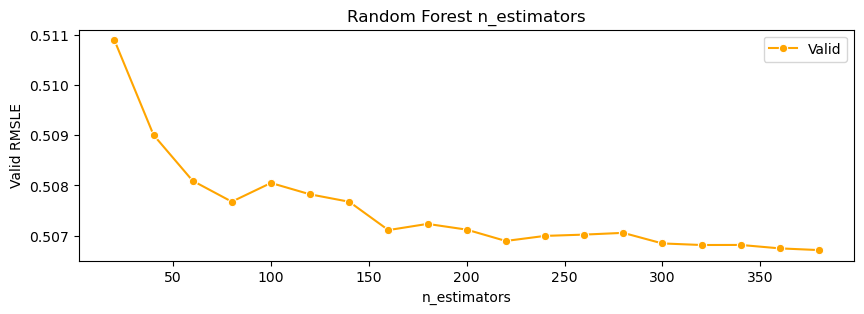

In [19]:
plt.figure(figsize = (10,3), dpi = 100)
#sns.lineplot(x = n_estimators_result['n_estimators'], y = n_estimators_result['mean_rmsle_train'], marker = 'o', color= 'blue', label= 'Train')
sns.lineplot(x = n_estimators_result['n_estimators'], y = n_estimators_result['mean_rmsle_valid'], marker = 'o', color= 'orange', label= 'Valid')
plt.title('Random Forest n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Valid RMSLE')
plt.show()

**RMSLE (.5068)** on Validation gets stabalized at around **n_estimators = 220**

### 2. max_depth

In [20]:
def get_depth(evaluation_set, min_r, max_r):
    
    results = []
    
    for depth in range(min_r, max_r, 1):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= 220,
                                     max_depth= depth,
                                     min_samples_split= 5,
                                     min_samples_leaf= 5)
            
            model.fit(train_data_x, train_data_y)
            
            train_preds = model.predict(train_data_x)
            valid_preds = model.predict(valid_data_x)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results 
            SCORE_TRAIN.append(get_rmsle(train_data_y, train_preds))
            SCORE_VALID.append(get_rmsle(valid_data_y, valid_preds))
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With max_depth:\t' + str(depth) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['max_depth'] = depth
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [22]:
depth_result = get_depth(evaluation_sets ,min_r = 1, max_r = 25)

With max_depth:	1	Mean_RMSLE_Train:	0.7794905395168714	Mean_RMSLE_Valid:	0.784624327773452
With max_depth:	2	Mean_RMSLE_Train:	0.644077162068427	Mean_RMSLE_Valid:	0.6575685404144548
With max_depth:	3	Mean_RMSLE_Train:	0.5508830312988297	Mean_RMSLE_Valid:	0.5794778617061914
With max_depth:	4	Mean_RMSLE_Train:	0.4893650285446031	Mean_RMSLE_Valid:	0.5362153226404633
With max_depth:	5	Mean_RMSLE_Train:	0.447432739468529	Mean_RMSLE_Valid:	0.5068919243758093
With max_depth:	6	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With max_depth:	7	Mean_RMSLE_Train:	0.39192763861945284	Mean_RMSLE_Valid:	0.487011894425654
With max_depth:	8	Mean_RMSLE_Train:	0.37008164096515495	Mean_RMSLE_Valid:	0.48435282798674806
With max_depth:	9	Mean_RMSLE_Train:	0.35050140381162537	Mean_RMSLE_Valid:	0.483437538093904
With max_depth:	10	Mean_RMSLE_Train:	0.33319717905067375	Mean_RMSLE_Valid:	0.483457080617715
With max_depth:	11	Mean_RMSLE_Train:	0.3185814411334741	Mean_RMSLE_Valid:	0.4834

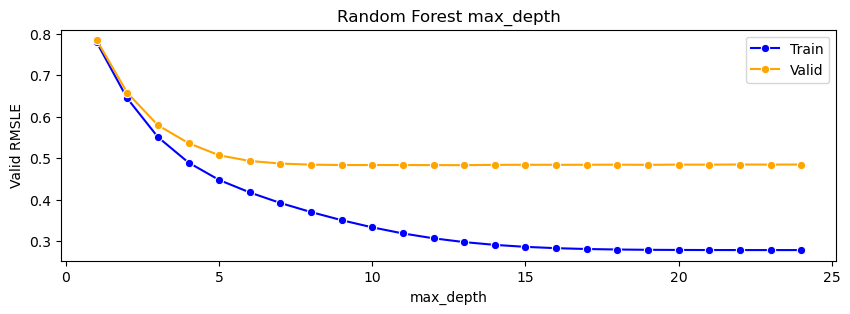

In [23]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x = depth_result['max_depth'], y = depth_result['mean_rmsle_train'], marker = 'o', color= 'blue', label= 'Train')
sns.lineplot(x = depth_result['max_depth'], y = depth_result['mean_rmsle_valid'], marker = 'o', color= 'orange', label= 'Valid')
plt.title('Random Forest max_depth')
plt.xlabel('max_depth')
plt.ylabel('Valid RMSLE')
plt.show()

After **max_depth = 6** the model is starting to overfit on the training data. At this value **RMSLE = 0.4932**. 

### 3. min_samples_split

In [25]:
def get_sample_split(evaluation_set, min_r, max_r):
    
    results = []
    
    for split in range(min_r, max_r, 1):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= 220,
                                     max_depth= 6,
                                     min_samples_split= split,
                                     min_samples_leaf= 5)
            
            model.fit(train_data_x, train_data_y)
            
            train_preds = model.predict(train_data_x)
            valid_preds = model.predict(valid_data_x)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results 
            SCORE_TRAIN.append(get_rmsle(train_data_y, train_preds))
            SCORE_VALID.append(get_rmsle(valid_data_y, valid_preds))
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With min_samples_split:\t' + str(split) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['min_samples_split'] = split
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [26]:
split_result = get_sample_split(evaluation_sets ,min_r = 1, max_r = 20)

With min_samples_split:	1	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	2	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	3	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	4	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	5	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	6	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	7	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	8	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	9	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_split:	10	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591

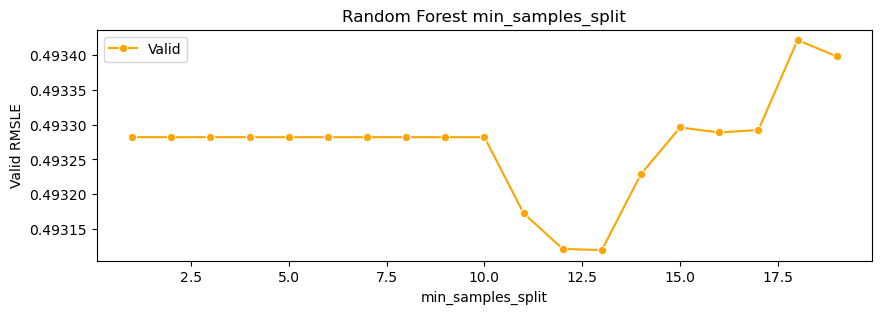

In [32]:
plt.figure(figsize = (10,3), dpi = 100)
#sns.lineplot(x = split_result['min_samples_split'], y = split_result['mean_rmsle_train'], marker = 'o', color= 'blue', label= 'Train')
sns.lineplot(x = split_result['min_samples_split'], y = split_result['mean_rmsle_valid'], marker = 'o', color= 'orange', label= 'Valid')
plt.title('Random Forest min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Valid RMSLE')
plt.show()

There's not much change in the **RMSLE (0.4932)** by changing min_samples_split hyperparameter. So we're going to keep it to **min_samples_split = 5**

### 4. min_samples_leaf

In [33]:
def get_sample_leaf(evaluation_set, min_r, max_r):
    
    results = []
    
    for leaf in range(min_r, max_r, 1):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            model= RandomForestRegressor(random_state= 0,
                                     n_estimators= 220,
                                     max_depth= 6,
                                     min_samples_split= 5,
                                     min_samples_leaf= leaf)
            
            model.fit(train_data_x, train_data_y)
            
            train_preds = model.predict(train_data_x)
            valid_preds = model.predict(valid_data_x)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results 
            SCORE_TRAIN.append(get_rmsle(train_data_y, train_preds))
            SCORE_VALID.append(get_rmsle(valid_data_y, valid_preds))
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With min_samples_leaf:\t' + str(leaf) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['min_samples_leaf'] = leaf
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [34]:
leaf_result = get_sample_leaf(evaluation_sets ,min_r = 1, max_r = 20)

With min_samples_leaf:	1	Mean_RMSLE_Train:	0.4171371138832172	Mean_RMSLE_Valid:	0.49578583975986645
With min_samples_leaf:	2	Mean_RMSLE_Train:	0.4168657606840595	Mean_RMSLE_Valid:	0.4939632760691871
With min_samples_leaf:	3	Mean_RMSLE_Train:	0.4169305316384413	Mean_RMSLE_Valid:	0.49332035066483026
With min_samples_leaf:	4	Mean_RMSLE_Train:	0.4171205160625079	Mean_RMSLE_Valid:	0.4930971660723411
With min_samples_leaf:	5	Mean_RMSLE_Train:	0.41737458071085604	Mean_RMSLE_Valid:	0.493281778119591
With min_samples_leaf:	6	Mean_RMSLE_Train:	0.4176499338271816	Mean_RMSLE_Valid:	0.49320955922487975
With min_samples_leaf:	7	Mean_RMSLE_Train:	0.41796161960431316	Mean_RMSLE_Valid:	0.49320645829533494
With min_samples_leaf:	8	Mean_RMSLE_Train:	0.4183386680609209	Mean_RMSLE_Valid:	0.492869860339957
With min_samples_leaf:	9	Mean_RMSLE_Train:	0.41867577924107785	Mean_RMSLE_Valid:	0.4926933425659547
With min_samples_leaf:	10	Mean_RMSLE_Train:	0.4190282447595121	Mean_RMSLE_Valid:	0.4922255348456895
With

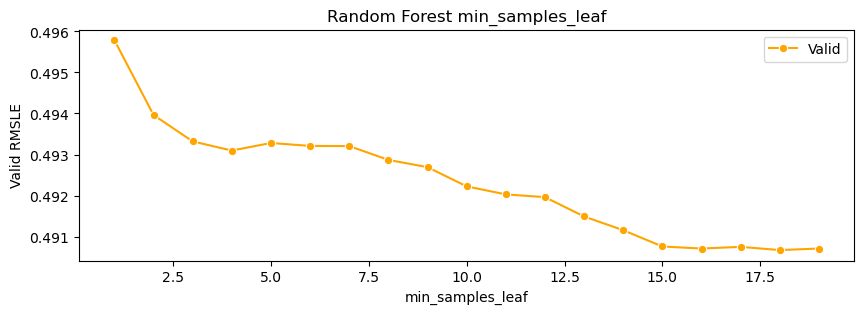

In [36]:
plt.figure(figsize = (10,3), dpi = 100)
#sns.lineplot(x = leaf_result['min_samples_leaf'], y = leaf_result['mean_rmsle_train'], marker = 'o', color= 'blue', label= 'Train')
sns.lineplot(x = leaf_result['min_samples_leaf'], y = leaf_result['mean_rmsle_valid'], marker = 'o', color= 'orange', label= 'Valid')
plt.title('Random Forest min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('Valid RMSLE')
plt.show()

At **min_samples_leaf = 16** the **RMSLE (0.49071)** is the lowest and starting to get stable.

**CONCLUSION :**
* n_estimators = 220
* max_depth = 6
* min_samples_split = 5
* min_samples_leaf = 16